# TM-G testing

In [11]:
import pandas as pd

df = pd.read_csv('Data/hourly_data_ff.csv')
time = df['timestamp']
df.drop(columns=['timestamp'], inplace=True)

In [12]:
import numpy as np
dfs = np.array_split(df,10)
times = np.array_split(time,10)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'Series.swapaxes' is deprecated and will be removed in a future version. Please use 'Series.transpose' instead.
  return bound(*args, **kwds)


The Granger causality test indicates that the only orderbook features that cause the volatility are ask_depth, bid_depth, bid_volume, spread and volume_difference. We thus train the model using only these features.


In [13]:
import matplotlib.pyplot as plt
from Models.TM_G import TM_G
from Model_eval.TM_eval import evaluate_TM
from sklearn.preprocessing import StandardScaler
from Models.CVal import cross_validation
import copy

feature_cols = df.columns.difference(['vol'])
predictions = []
for i in range(4, 9):
  df_train = pd.concat([copy.deepcopy(dfs[j]) for j in range(i-3,i-1)], ignore_index=True).reset_index(drop = True)
  df_validate = copy.deepcopy(dfs[i])
  df_test =copy.deepcopy(dfs[i+1])

  best_params = cross_validation(copy.deepcopy(df_train), copy.deepcopy(df_validate))
  print(f'Cross validated interval {i}')

  model = TM_G(n_features = df_train.shape[1]-1, lb = best_params['lb'], lambda_reg = best_params['lambda_reg'])
  new_df_train = pd.concat([df_train, df_validate], axis=0, ignore_index=True).reset_index(drop = True)
  scaler = StandardScaler()
  new_df_train[feature_cols] = scaler.fit_transform(new_df_train[feature_cols])
  model.train_model(df_train, epochs = 2000)
  df_test[feature_cols] = scaler.transform(df_test[feature_cols])
  print(f'Predicted interval {i+1}')

  _, _, y_pred, _ = evaluate_TM(model, df_test, plot = False)
  predictions.append(y_pred)

100%|██████████| 2000/2000 [00:03<00:00, 624.90it/s]


Cross validated interval 4


100%|██████████| 2000/2000 [00:01<00:00, 1027.76it/s]


Predicted interval 5


100%|██████████| 2000/2000 [00:03<00:00, 663.67it/s]


Cross validated interval 5


100%|██████████| 2000/2000 [00:02<00:00, 873.64it/s]


Predicted interval 6


100%|██████████| 2000/2000 [00:03<00:00, 552.97it/s]


Cross validated interval 6


100%|██████████| 2000/2000 [00:02<00:00, 826.87it/s]


Predicted interval 7


100%|██████████| 2000/2000 [00:03<00:00, 655.85it/s]


Cross validated interval 7


100%|██████████| 2000/2000 [00:02<00:00, 916.94it/s] 


Predicted interval 8


100%|██████████| 2000/2000 [00:03<00:00, 650.24it/s]


Cross validated interval 8


100%|██████████| 2000/2000 [00:02<00:00, 669.94it/s]

Predicted interval 9


In [ ]:
final_pred = [predictions[j][i] for j in range(1,len(predictions)) for i in range(len(predictions[j])) ]
print(len(final_pred))
dfs = [dfs[i][31:] for i in range(10)]
merged = pd.concat(dfs[4:], ignore_index=True).reset_index(drop = True)
print(merged.shape)

1375
(1375, 11)


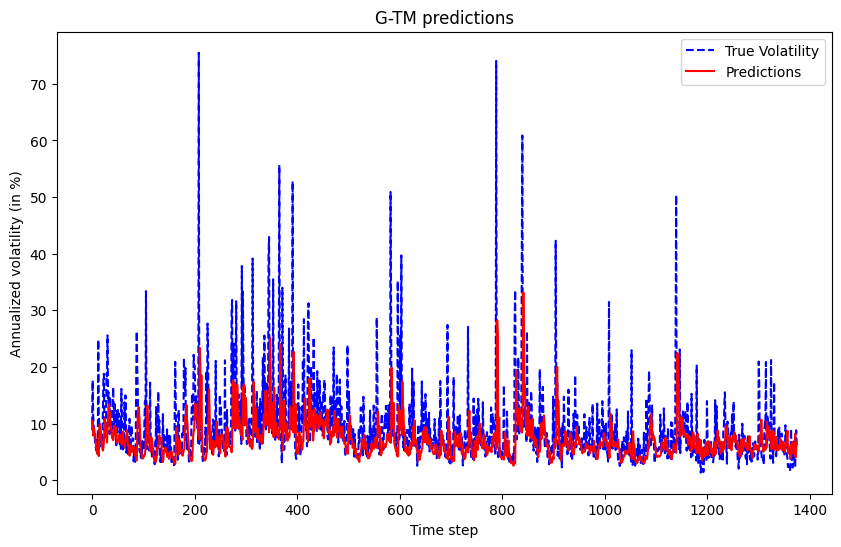

In [12]:
plt.figure(figsize = (10,6))
plt.plot( merged['vol'], label = 'True Volatility', color = 'blue', linestyle = '--')
plt.plot( final_pred, label = 'Predictions', color = 'red')
plt.title('G-TM predictions')
plt.ylabel('Annualized volatility (in %)')
plt.xlabel('Time step')
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
for i in range(6):
  start = int(np.sum([len(dfs[j]) for j in range(i)]))
  rmse = np.sqrt(mean_squared_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])])) / 100 # Undo percentage scaling
  mae = mean_absolute_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])]) / 100 
  print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Test RMSE: 0.0739, MAE: 0.0423
Test RMSE: 0.0906, MAE: 0.0540
Test RMSE: 0.0635, MAE: 0.0371
Test RMSE: 0.0871, MAE: 0.0428
Test RMSE: 0.0540, MAE: 0.0287
Test RMSE: 0.0350, MAE: 0.0238


In [14]:
dfs = np.array_split(df,10)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


We now check if adding our remaining features lead to improved performance.

In [15]:
predictions = []
for i in range(4, 9):
  df_train = pd.concat([copy.deepcopy(dfs[j]) for j in range(i-3,i-1)], ignore_index=True).reset_index(drop = True)
  df_validate = copy.deepcopy(dfs[i])
  df_test =copy.deepcopy(dfs[i+1])

  best_params = cross_validation(copy.deepcopy(df_train), copy.deepcopy(df_validate))
  print(f'Cross validated interval {i}')

  model = TM_G(n_features = df_train.shape[1]-1, lb = best_params['lb'], lambda_reg = best_params['lambda_reg'])
  new_df_train = pd.concat([df_train, df_validate], axis=0, ignore_index=True).reset_index(drop = True)
  scaler = StandardScaler()
  new_df_train[feature_cols] = scaler.fit_transform(new_df_train[feature_cols])
  model.train_model(df_train, epochs = 2000)
  df_test[feature_cols] = scaler.transform(df_test[feature_cols])
  print(f'Predicted interval {i+1}')

  _, _, y_pred, _ = evaluate_TM(model, df_test, plot = False)
  predictions.append(y_pred)

100%|██████████| 2000/2000 [00:03<00:00, 643.87it/s]


Cross validated interval 4


100%|██████████| 2000/2000 [00:03<00:00, 626.00it/s]


Predicted interval 5


100%|██████████| 2000/2000 [00:03<00:00, 658.67it/s]


Cross validated interval 5


100%|██████████| 2000/2000 [00:02<00:00, 981.36it/s] 


Predicted interval 6


100%|██████████| 2000/2000 [00:04<00:00, 499.47it/s]


Cross validated interval 6


100%|██████████| 2000/2000 [00:02<00:00, 920.42it/s] 


Predicted interval 7


100%|██████████| 2000/2000 [00:03<00:00, 511.02it/s]


Cross validated interval 7


100%|██████████| 2000/2000 [00:02<00:00, 748.46it/s]


Predicted interval 8


100%|██████████| 2000/2000 [00:03<00:00, 545.31it/s]


Cross validated interval 8


100%|██████████| 2000/2000 [00:01<00:00, 1021.96it/s]

Predicted interval 9


In [148]:
final_pred = [predictions[j][i] for j in range(1,len(predictions)) for i in range(len(predictions[j])) ]
print(len(final_pred))
dfs = [dfs[i][31:] for i in range(10)]
merged = pd.concat(dfs[4:], ignore_index=True).reset_index(drop = True)
print(merged.shape)

1375
(1375, 11)


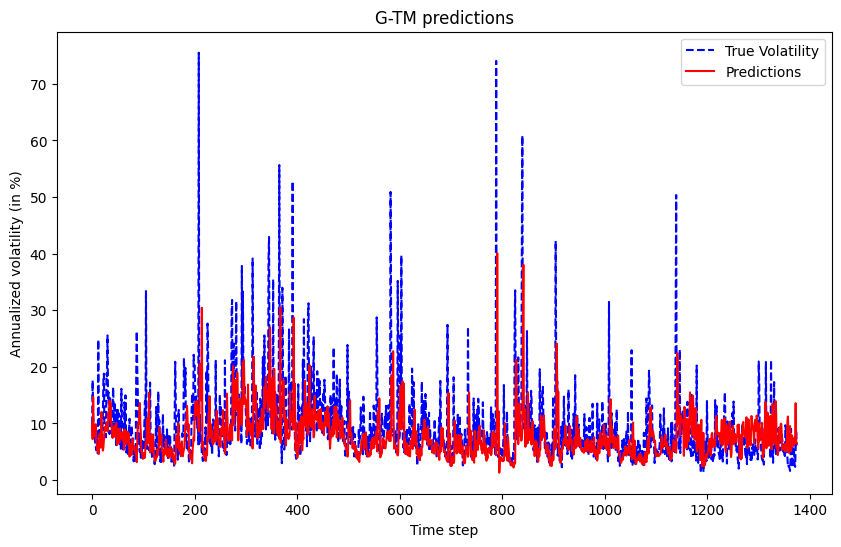

In [149]:
plt.figure(figsize = (10,6))
plt.plot( merged['vol'], label = 'True Volatility', color = 'blue', linestyle = '--')
plt.plot( final_pred, label = 'Predictions', color = 'red')
plt.title('G-TM predictions')
plt.ylabel('Annualized volatility (in %)')
plt.xlabel('Time step')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
for i in range(6):
  start = int(np.sum([len(dfs[j]) for j in range(i)]))
  rmse = np.sqrt(mean_squared_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])])) / 100 # Undo percentage scaling
  mae = mean_absolute_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])]) / 100 
  print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Test RMSE: 0.0762, MAE: 0.0440
Test RMSE: 0.0872, MAE: 0.0541
Test RMSE: 0.0639, MAE: 0.0379
Test RMSE: 0.0902, MAE: 0.0452
Test RMSE: 0.0540, MAE: 0.0298
Test RMSE: 0.0427, MAE: 0.0326


# Sentiment TM-G testing

The granger causality test indicates that our sentiment time series Granger-causes the volatility up to two lags, so we choose the look back window for the sentiment component to be 2.

In [2]:
sent = pd.read_csv('Data/sentiment.csv')

In [5]:
dfs = np.array_split(df,10)
sents = np.array_split(sent,10)

for i in range(10):
    dfs[i]['sentiment'] = sents[i]['Aggregate sentiment'].values


In [10]:
import matplotlib.pyplot as plt
from Models.TM_SG import TM_SG
from Model_eval.TM_eval import evaluate_STM
from sklearn.preprocessing import StandardScaler
from Models.CVal import cross_validation
import copy
feature_cols = df.columns.difference(['vol', 'sentiment'])
predictions = []
for i in range(4, 9):
  df_train = pd.concat([copy.deepcopy(dfs[j]) for j in range(i-3,i-1)], ignore_index=True).reset_index(drop = True)
  df_validate = copy.deepcopy(dfs[i])
  df_test =copy.deepcopy(dfs[i+1])

  best_params = cross_validation(copy.deepcopy(df_train), copy.deepcopy(df_validate))
  print(f'Cross validated interval {i}')

  model = TM_SG(n_features = len(feature_cols), lb = best_params['lb'], lambda_reg = best_params['lambda_reg'])
  new_df_train = pd.concat([df_train, df_validate], axis=0, ignore_index=True).reset_index(drop = True)
  scaler = StandardScaler()
  new_df_train[feature_cols] = scaler.fit_transform(new_df_train[feature_cols])
  model.train_model(df_train, epochs = 2000)
  df_test[feature_cols] = scaler.transform(df_test[feature_cols])
  print(f'Predicted interval {i+1}')

  _, _, y_pred = evaluate_STM(model, df_test, plot = False)
  predictions.append(y_pred)

100%|██████████| 2000/2000 [00:03<00:00, 652.77it/s]


Cross validated interval 4


100%|██████████| 2000/2000 [00:04<00:00, 465.06it/s]


Predicted interval 5


100%|██████████| 2000/2000 [00:02<00:00, 696.76it/s]


Cross validated interval 5


100%|██████████| 2000/2000 [00:02<00:00, 864.77it/s]


Predicted interval 6


100%|██████████| 2000/2000 [00:03<00:00, 604.08it/s]


Cross validated interval 6


100%|██████████| 2000/2000 [00:03<00:00, 654.14it/s]


Predicted interval 7


100%|██████████| 2000/2000 [00:03<00:00, 636.84it/s]


Cross validated interval 7


100%|██████████| 2000/2000 [00:02<00:00, 861.18it/s]


Predicted interval 8


100%|██████████| 2000/2000 [00:03<00:00, 505.03it/s]


Cross validated interval 8


100%|██████████| 2000/2000 [00:06<00:00, 315.63it/s]


Predicted interval 9


In [ ]:
final_pred = [predictions[j][i] for j in range(len(predictions)) for i in range(len(predictions[j])) ]
print(len(final_pred))
dfs = [dfs[i][11:] for i in range(10)]
merged = pd.concat(dfs[4:], ignore_index=True).reset_index(drop = True)
print(merged.shape)

1495
(1495, 12)


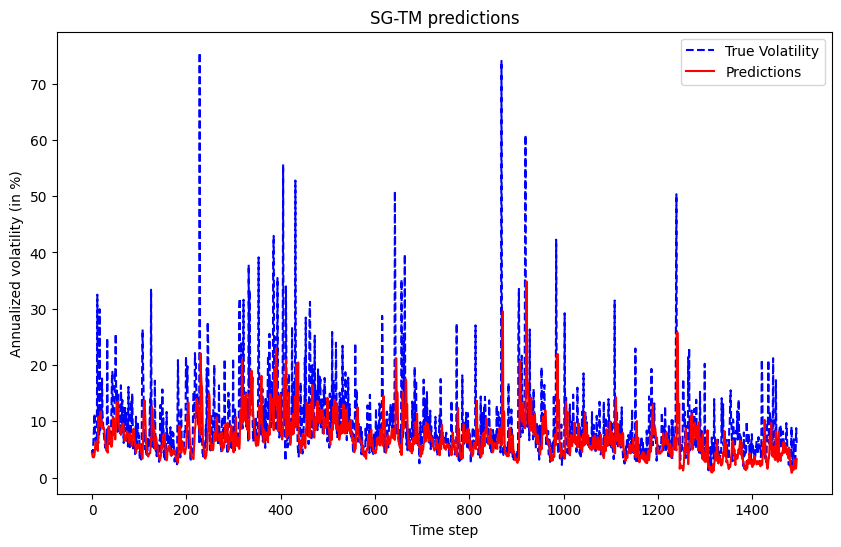

In [70]:
plt.figure(figsize = (10,6))
plt.plot( merged['vol'], label = 'True Volatility', color = 'blue', linestyle = '--')
plt.plot( final_pred, label = 'Predictions', color = 'red')
plt.title('SG-TM predictions')
plt.ylabel('Annualized volatility (in %)')
plt.xlabel('Time step')
plt.legend()
plt.show()

In [69]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
for i in range(6):
  start = int(np.sum([len(dfs[j]) for j in range(i)]))
  rmse = np.sqrt(mean_squared_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])])) / 100 # Undo percentage scaling
  mae = mean_absolute_error(merged['vol'][start: start + len(dfs[i])], final_pred[start: start + len(dfs[i])]) / 100 
  print(f"Test RMSE: {rmse:.4f}, MAE: {mae:.4f}")

Test RMSE: 0.0749, MAE: 0.0432
Test RMSE: 0.0881, MAE: 0.0538
Test RMSE: 0.0628, MAE: 0.0370
Test RMSE: 0.0846, MAE: 0.0413
Test RMSE: 0.0548, MAE: 0.0305
Test RMSE: 0.0497, MAE: 0.0343
